In [1]:
import sys
sys.path.append("/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/ml-xai")

from WISP.WISP import *

# Make it deterministic

In [2]:
data = pd.read_csv('/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/delaney-processed-Nr.csv')

Smiles_Column_Name = "smiles"
Target_Column_Name = 'measured log solubility in mols per litre'
ID_Column_Name = 'Nr'
working_dir = '/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/'
task_type = 'regression'

with suppress_output():
    std = Standardizer(max_num_atoms=1000,#tipp jan: 100
                max_num_tautomers=10,
                include_stereoinfo=False,
                keep_largest_fragment=True, 
                canonicalize_tautomers=True, 
                normalize=True, 
                sanitize_mol=True)
data["smiles_std"] = data[Smiles_Column_Name].apply(lambda smi: std(smi)[0]) 
data = filter_duplicates(data, 'smiles_std', Target_Column_Name)

In [3]:
data, ALLfeatureCOLUMS, model_types = features_and_reg_model_types(data)
test, target_test, train = split_data(data, Target_Column_Name, working_dir)

In [4]:
import chemprop
import random

import pandas as pd
import matplotlib.pyplot as plt
from lightning import pytorch as pl
from pathlib import Path

from lightning.pytorch import seed_everything

from chemprop import data as chempropdata############################
from chemprop import featurizers, models, nn
from chemprop.nn import metrics
from chemprop.models import multi

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pdb
import numpy as np

from lightning.pytorch.callbacks import ModelCheckpoint

import torch

import os
from glob import glob

#to not get the output
import logging
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

random.seed(6)
np.random.seed(6)
torch.manual_seed(6)
torch.use_deterministic_algorithms(True)

class SklChemprop:

    def __init__(self,problem_type:str,max_epochs:int,Smiles_Column_Name:str, Target_Column_Name:str, working_dir:str):
        # TODO: Hyperparameters should be passed here
        self.problem_type = problem_type
        self.max_epochs = max_epochs
        self.Smiles_Column_Name = Smiles_Column_Name
        self.Target_Column_Name = Target_Column_Name
        self.working_dir = working_dir

        self.mpnn = None
        self._load_latest_checkpoint()

    def _load_latest_checkpoint(self):
        checkpoint_dir = self.working_dir + 'checkpoints/'
        if not os.path.exists(checkpoint_dir):#skipps loading if there is no checkpoint dir
            return
        ckpt_files = glob(os.path.join(checkpoint_dir, 'best*.ckpt'))
        if not ckpt_files:#skipps loading if there is no checkpoint file
            return
        # Get most recent checkpoint and set as self model
        latest_ckpt = max(ckpt_files, key=os.path.getmtime)
        self.mpnn = models.MPNN.load_from_checkpoint(latest_ckpt) 

    def fit(self,df_input:"pd.Dataframe"):
        df_input.reset_index(inplace=True)
        num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
        smiles_column = self.Smiles_Column_Name # name of the column containing SMILES strings
        target_columns = [self.Target_Column_Name] # list of names of the columns containing targets
        smis = df_input.loc[:, smiles_column].values
        ys = df_input.loc[:, target_columns].values
        
        all_data = [chempropdata.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]
        
        #train validation split
        nr_val_samples = round(len(df_input) / 5) # 80/20 split
        val = df_input.sample(n=nr_val_samples, random_state=6)
        train_set = df_input.drop(val.index)

        # get the indices/data
        train_indices = [train_set.index.tolist()]
        val_indices = [val.index.tolist()]
        train_data, val_data, _ = chempropdata.split_data_by_indices(all_data, train_indices, val_indices)

        #preprocess data
        featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

        train_dset = chempropdata.MoleculeDataset(train_data[0], featurizer)
        scaler = train_dset.normalize_targets()
        val_dset = chempropdata.MoleculeDataset(val_data[0], featurizer)
        val_dset.normalize_targets(scaler)

        train_loader = chempropdata.build_dataloader(train_dset, num_workers=num_workers, shuffle=False, seed=6)
        val_loader = chempropdata.build_dataloader(val_dset, num_workers=num_workers, shuffle=False, seed=6)

        mp = nn.BondMessagePassing()
        agg = nn.MeanAggregation()

        output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)

        ffn = nn.RegressionFFN(output_transform=output_transform)

        batch_norm = True
        metric_list = [metrics.MAE()]#[nn.metrics.RMSE(), nn.metrics.R2score()]

        seed_everything(6, workers=True)
        mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)

        # Checkpointing
        checkpointing = ModelCheckpoint(
        self.working_dir + "checkpoints",  # Directory where model checkpoints will be saved
        "best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
        "val_loss",  # Metric used to select the best checkpoint (based on validation loss)
        mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
        )

        trainer = pl.Trainer(
            logger=False,
            enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
            enable_progress_bar=False,
            accelerator="cpu",
            devices=1,
            max_epochs=self.max_epochs, # number of epochs to train for
            callbacks=[checkpointing], # Use the configured checkpoint callback
            deterministic=True,
        )
        print(trainer)
        trainer.fit(mpnn, train_loader, val_loader)
        self._load_latest_checkpoint()

    
    def predict(self, smiles):#df_input:"pd.Dataframe"
        num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
        #smiles_column = self.Smiles_Column_Name # name of the column containing SMILES strings
        #smis = df_input.loc[:, smiles_column].values
        smis = [smi for sublist in smiles for smi in sublist]
        
        all_data = [chempropdata.MoleculeDatapoint.from_smi(smi) for smi in smis]

        #preprocess data
        featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
        test_dset = chempropdata.MoleculeDataset(all_data, featurizer)
        test_loader = chempropdata.build_dataloader(test_dset, num_workers=num_workers, shuffle=False, seed=6)

        #loader etc from previous
        with torch.inference_mode():
            trainer = pl.Trainer(
                logger=False,
                enable_progress_bar=False,
                accelerator="cpu",
                devices=1,
                deterministic=True
            )
            test_preds = trainer.predict(self.mpnn, test_loader)
        test_preds = np.concatenate(test_preds, axis=0)

        return test_preds
    
def get_features(data, CLOUMS):
    """
    Preprocesses the features according to theyr type.

    Keyword arguments:
    -- data: Table where the features are stored.
    -- CLOUMS: Colum where the feature is stored.

    Returns:
    -- X: Preprocessed feature.
    """
    features = []

    for i in CLOUMS:
        if type(data[i].values[0]) is np.ndarray:
            x = np.stack(data[i].values)
        else:
            x = data[i].values.reshape(-1, 1)
        features.append(x)

    X = np.concatenate(features, axis=1)
    return X
    
def train_GNN(train, Smiles_Column_Name, Target_Column_Name, working_dir):
    model_GNN = SklChemprop(problem_type="regression", max_epochs=20, Smiles_Column_Name=Smiles_Column_Name, Target_Column_Name=Target_Column_Name, working_dir=working_dir)
    model_GNN.fit(train)
    
    prep_smiles = get_features(train, [Smiles_Column_Name])

    model_GNN = SklChemprop(problem_type="regression", max_epochs=20, Smiles_Column_Name=Smiles_Column_Name, Target_Column_Name=Target_Column_Name, working_dir=working_dir)
    predictions = model_GNN.predict(prep_smiles)
    target = train[Target_Column_Name].values

    r2 = np.corrcoef(target.flatten(), predictions.flatten())[0,1]**2
    RMSE_z = np.sqrt(np.mean((target.flatten() - predictions.flatten())**2))
    RMSE_n = np.sqrt(np.mean((target.flatten() - np.mean(target.flatten()))**2))
    R2 = 1 - RMSE_z**2/RMSE_n**2
    MAE = mean_absolute_error(target.flatten(), predictions.flatten())
    mse = mean_squared_error(target.flatten(), predictions.flatten())
    rmse = np.sqrt(mse)

    return r2, R2, MAE, rmse

def identity(x):
    return x

In [5]:
random.seed(6)
np.random.seed(6)
torch.manual_seed(6)
torch.use_deterministic_algorithms(True)

use_GNN = True
#model, feature_function, featureCOLUMS  = get_best_reg_model(model_types, ALLfeatureCOLUMS, train, Target_Column_Name, working_dir, use_GNN)

results = []

if use_GNN is True:
    checkpoint_dir = working_dir + 'checkpoints/' 
    if os.path.exists(checkpoint_dir) and os.path.isdir(checkpoint_dir):
        shutil.rmtree(checkpoint_dir) #deletes old checkpoint dir
    if 'level_0' in train.columns:
        train.drop(columns=['level_0'], inplace=True)
    r2, R2, MAE, RMSE = train_GNN(train, 'smiles_std', Target_Column_Name, working_dir)#############################
    model_GNN = SklChemprop(problem_type="regression", max_epochs=20, Smiles_Column_Name='smiled_std', Target_Column_Name=Target_Column_Name, working_dir=working_dir)##################
    results.append({'Feature': 'smiles_std','Model_Type': 'SklChemprop','Model': model_GNN,'r2': r2,'R2': R2,'MAE': MAE,'RMSE': RMSE})##################
print(results)

Seed set to 6


[{'Feature': 'smiles_std', 'Model_Type': 'SklChemprop', 'Model': <__main__.SklChemprop object at 0x316220c10>, 'r2': 0.9385264854849089, 'R2': 0.9378934377527203, 'MAE': 0.38843027861357543, 'RMSE': 0.5156884433594188}]


In [8]:
#random.seed(6)
#np.random.seed(6)
torch.manual_seed(6)
#torch.use_deterministic_algorithms(True)

use_GNN = True
results = []

if use_GNN is True:
    checkpoint_dir = working_dir + 'checkpoints/' 
    if os.path.exists(checkpoint_dir) and os.path.isdir(checkpoint_dir):
        shutil.rmtree(checkpoint_dir) #deletes old checkpoint dir
    if 'level_0' in train.columns:
        train.drop(columns=['level_0'], inplace=True)
    r2, R2, MAE, RMSE = train_GNN(train, 'smiles_std', Target_Column_Name, working_dir)#############################
    model_GNN = SklChemprop(problem_type="regression", max_epochs=20, Smiles_Column_Name='smiled_std', Target_Column_Name=Target_Column_Name, working_dir=working_dir)##################
    results.append({'Feature': 'smiles_std','Model_Type': 'SklChemprop','Model': model_GNN,'r2': r2,'R2': R2,'MAE': MAE,'RMSE': RMSE})##################
print(results)

Seed set to 6


[{'Feature': 'smiles_std', 'Model_Type': 'SklChemprop', 'Model': <__main__.SklChemprop object at 0x31484e350>, 'r2': 0.9385264854849089, 'R2': 0.9378934377527203, 'MAE': 0.38843027861357543, 'RMSE': 0.5156884433594188}]


In [102]:
result_subtract = pred1 - pred2

In [103]:
for i in result_subtract:
    if i != 0:
        print(i)

# Make it fit for WISP

[14:41:26] Initializing MetalDisconnector
[14:41:26] Running MetalDisconnector
[14:41:26] Initializing Normalizer
[14:41:26] Running Normalizer
[14:41:26] Running LargestFragmentChooser
[14:41:26] Running Uncharger
[14:41:26] Initializing MetalDisconnector
[14:41:26] Running MetalDisconnector
[14:41:26] Initializing Normalizer
[14:41:26] Running Normalizer
[14:41:26] Initializing MetalDisconnector
[14:41:26] Running MetalDisconnector
[14:41:26] Initializing MetalDisconnector
[14:41:26] Running MetalDisconnector
[14:41:26] Initializing Normalizer
[14:41:26] Running Normalizer
[14:41:26] Running LargestFragmentChooser
[14:41:26] Running Uncharger
[14:41:26] Initializing MetalDisconnector
[14:41:26] Running MetalDisconnector
[14:41:26] Initializing Normalizer
[14:41:26] Running Normalizer
[14:41:26] Initializing Normalizer
[14:41:26] Running Normalizer
[14:41:26] Initializing MetalDisconnector
[14:41:26] Running MetalDisconnector
[14:41:26] Initializing Normalizer
[14:41:26] Running Norma

Standardization done
Best Model:  <WISP.chemprop.SklChemprop object at 0x3b06a7f10>
With a MAE of:  1.0962804990768433
Feature:  smiles_std
Performance on testset(r2, R2, MAE, RMSE, Maximal Error, MSE): 0.9999999999999996 ; -0.009183920986516547 ; 2.0968468084335328 ; 2.3246015113517235 ; 3.1003435192108153 ; 5.403772186578717


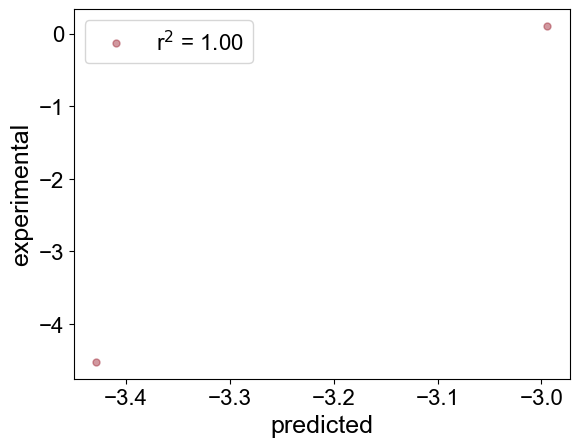

Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoi

XSMILES Attribution done
-0.11394369602203368 0.11394369602203368
[-0.002539118053391576, -0.005954384803771973, 0.01006277371197939, -0.004568542819470167, 0.015262722969055176, -0.004745755810290575, 0.01586318016052246, -0.005794661585241556, -0.003800358157604933, 0.014839808456599712, -0.004353966098278761, 0.016067465767264366, -0.005192552227526903, 0.011238271370530128, 0.016943177208304405, 0.01461020391434431, 0.01759195327758789, 0.014728914946317673, 0.017254194244742393, 0.014618548564612865, 0.016967138275504112, 0.014584389515221119, 0.01761770248413086, 0.014727548696100712, 0.01726730726659298, 0.014629646204411983, -0.047989487648010254, -0.012576389126479626, -0.011266136541962624, -0.010418081656098366, -0.011322498321533203, -0.013013839721679688]
N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c1ccccc1
-0.11394369602203368 0.11394369602203368
[-0.005257606506347656, -0.09182083606719971, -0.0025582313537597656, -0.003307819366455078, -0.005480384919792414, -0.0939285

In [32]:
data = WISP('/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/', 
     '/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/delaney-processed-Nr-short.csv',
     "Nr",
     "smiles", 
     'measured log solubility in mols per litre',
     model_available=None)

In [10]:
data = pd.read_csv('/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/Attribution_Data.csv')

In [33]:
smiles = 'C'
attributions = [-1.0932]
attributions = [float(x) for x in attributions]
print(attributions)
vmin = -0.0923452377319336
vmax = 0.0923452377319336
mol = Chem.MolFromSmiles(smiles, sanitize=False)
Chem.SanitizeMol(mol)#to keep the explicit hydrogens

# Draw similarity map
draw2d = Draw.MolDraw2DCairo(900, 900)
d = GetSimilarityMapFromWeightsWithScale(mol, attributions, draw2d, '#10384f', '#9C0D38', vmin, vmax)
d.FinishDrawing()

png_data = draw2d.GetDrawingText()
display(Image(data=png_data))

[-1.0932]


ValueError: too few atoms

In [2]:
data_LCAP = pd.read_csv('/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/ESOL.csv')

In [5]:
model = SklChemprop(problem_type="regression", max_epochs=20, Smiles_Column_Name="smiles", Target_Column_Name='measured log solubility in mols per litre', working_dir='/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/')#
model.fit(train)

TypeError: SklChemprop.__init__() got an unexpected keyword argument 'working_dir'

In [203]:
Target_Column_Name='measured log solubility in mols per litre'

predictions = model.predict(train)
target = train[Target_Column_Name].values

r2 = np.corrcoef(target.flatten(), predictions.flatten())[0,1]**2

RMSE_z = np.sqrt(np.mean((target.flatten() - predictions.flatten())**2))
RMSE_n = np.sqrt(np.mean((target.flatten() - np.mean(target.flatten()))**2))
R2 = 1 - RMSE_z**2/RMSE_n**2

MAE = mean_absolute_error(target.flatten(), predictions.flatten())

mse = mean_squared_error(target.flatten(), predictions.flatten())
rmse = np.sqrt(mse)

print(r2, R2, MAE, rmse)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


0.9392137186205226 0.9365797692870366 0.383763387043566 0.5350001106415875


In [23]:
data_LCAP

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


In [24]:
X_data_attributions_1 = get_features(data_LCAP, ['smiles'])

In [25]:
X_data_attributions_1

array([['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '],
       ['Cc1occc1C(=O)Nc2ccccc2'],
       ['CC(C)=CCCC(C)=CC(=O)'],
       ...,
       ['CCSCCSP(=S)(OC)OC'],
       ['CCC(C)C'],
       ['COP(=O)(OC)OC(=CCl)c1cc(Cl)c(Cl)cc1Cl']], dtype=object)

In [39]:
def train_GNN(train, Smiles_Column_Name, Target_Column_Name, working_dir):
    model_GNN = SklChemprop(problem_type="regression", max_epochs=20, Smiles_Column_Name=Smiles_Column_Name, Target_Column_Name=Target_Column_Name, working_dir=working_dir)
    model_GNN.fit(train)

    prep_smiles = get_features(train, 'smiles')

    predictions = model_GNN.predict(prep_smiles)
    target = train[Target_Column_Name].values

    r2 = np.corrcoef(target.flatten(), predictions.flatten())[0,1]**2
    RMSE_z = np.sqrt(np.mean((target.flatten() - predictions.flatten())**2))
    RMSE_n = np.sqrt(np.mean((target.flatten() - np.mean(target.flatten()))**2))
    R2 = 1 - RMSE_z**2/RMSE_n**2
    MAE = mean_absolute_error(target.flatten(), predictions.flatten())
    mse = mean_squared_error(target.flatten(), predictions.flatten())
    rmse = np.sqrt(mse)

    return r2, R2, MAE, rmse

In [40]:
r2, R2, MAE, rmse = train_GNN(train, 'smiles', 'measured log solubility in mols per litre', '/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/')

ValueError: cannot insert level_0, already exists

In [ ]:
print(r2, R2, MAE, rmse)

In [ ]:
def get_best_reg_model_with_GNN(model_types, ALLfeatureCOLUMS, train, Target_Column_Name, working_dir):
    results = []

    for model_arc in model_types:          
        for feature in ALLfeatureCOLUMS:
            model, r2, R2, MAE, RMSE = hp_search_helper(model_arc,train,Target_Column_Name,[str(feature)])
            results.append({'Feature': feature,'Model_Type': model_arc,'Model': model,'r2': r2,'R2': R2,'MAE': MAE,'RMSE': RMSE})
    r2, R2, MAE, RMSE = train_GNN(train, 'smiles_std', Target_Column_Name, working_dir)#############################
    results.append({'Feature': 'SimpleMoleculeMolGraphFeaturizer','Model_Type': 'SklChemprop','Model': 'SklChemprop','r2': r2,'R2': R2,'MAE': MAE,'RMSE': RMSE})##################
    

    results_df = pd.DataFrame(results)
    best_model_row = results_df.loc[results_df['MAE'].idxmin()]
    model = best_model_row['Model']
    print('Best Model: ', best_model_row['Model'])
    print('With a MAE of: ', best_model_row['MAE'])
    print('Feature: ', best_model_row['Feature'])
    results_df.to_csv(working_dir + "Grid-Search.csv", index=False)

    #pick feature function
    if best_model_row['Feature'] == 'Morgan_Fingerprint 2048Bit 2rad':
        feature_function = get_morgan_fingerprint
    if best_model_row['Feature'] == 'RDK_Fingerprint':
        feature_function = get_RDK_fingerprint
    if best_model_row['Feature'] == 'MACCS_Fingerprint':
        feature_function = get_MACCS_fingerprint

    featureCOLUMS = [best_model_row['Feature']]

    return model, feature_function, featureCOLUMS

In [208]:
class_name = model.__class__.__name__
print(class_name)

SklChemprop


In [ ]:
# built a model on the trainingset ---------------------------------------
#get model, r2, R2, MAE, RMSE on the trainingset
#feed into get_best_reg_model
#if its not the best model delete the checkpoints folder
#do something like train_and_evaluate_reg_model but for chemprop
#work around this one: model = pickle.load(open(working_dir + "model.pkl", 'rb'))

#attribute_atoms
#be able to mimic prediction = model.predict(prep_features_mutat) 
#same in the next step

#add_predictions
#be able to mimic predictions_1 = model.predict(X_data_attributions_1)

#model.named_steps['model'].__class__.__name__


In [200]:
#model = mpnn
predictions = model.predict(test)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


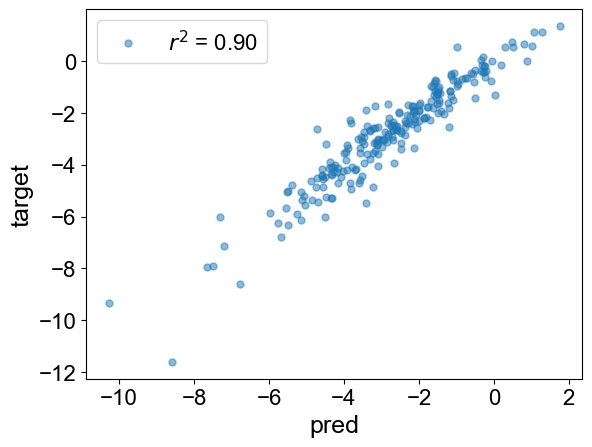

In [201]:
Xaxes = predictions
Yaxes = test['measured log solubility in mols per litre']

from sklearn.metrics import r2_score
r2 = r2_score(Yaxes, Xaxes)

plt.rcParams['font.family'] = 'arial'
plt.plot(Xaxes, Yaxes, '.', markersize=10, alpha=0.5)
plt.xlabel('pred', fontsize=18)
plt.ylabel('target', fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(['$r^2$ = ' + str(f"{r2:.2f}")], fontsize=16)#, loc=placeLegend
plt.show()

# Example single

In [ ]:
df_input = pd.read_csv('/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/Lipophilicity.csv')
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = 'smiles' # name of the column containing SMILES strings
target_columns = ['y'] # list of names of the columns containing targets
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]
list(data.SplitType.keys())
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))  # unpack the tuple into three separate lists
train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer)



train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)



mp = nn.BondMessagePassing()


agg = nn.MeanAggregation()



output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)



ffn = nn.RegressionFFN(output_transform=output_transform)



batch_norm = True
metric_list = [nn.metrics.RMSE(), nn.metrics.MAE()]
mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)

# Checkpointing?
checkpointing = ModelCheckpoint(
"/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/checkpoints",  # Directory where model checkpoints will be saved
"best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
"val_loss",  # Metric used to select the best checkpoint (based on validation loss)
mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
save_last=True,  # Always save the most recent checkpoint, even if it's not the best
)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=20, # number of epochs to train for
    callbacks=[checkpointing], # Use the configured checkpoint callback
)


trainer.fit(mpnn, train_loader, val_loader)



results = trainer.test(dataloaders=test_loader)




The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessag

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 53/53 [00:06<00:00,  8.53it/s, train_loss_step=0.0781, val_loss=0.276, train_loss_epoch=0.104]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 53/53 [00:06<00:00,  8.50it/s, train_loss_step=0.0781, val_loss=0.276, train_loss_epoch=0.104]

/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/checkpoints/best-epoch=17-val_loss=0.26.ckpt
Loaded model weights from the checkpoint at /Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/checkpoints/best-epoch=17-val_loss=0.26.ckpt


/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 11.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4493488073348999     │
│         test/rmse         │    0.5906854867935181     │
└───────────────────────────┴───────────────────────────┘

## Pred

In [320]:
mpnn = models.MPNN.load_from_checkpoint('/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/checkpoints/best-epoch=17-val_loss=0.26.ckpt')

#loader etc from previous
with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        accelerator="cpu",
        devices=1
    )
    test_preds = trainer.predict(mpnn, test_loader)
test_preds = np.concatenate(test_preds, axis=0)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.
/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7

Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 27.69it/s]


In [322]:
len(test_preds)

420

In [314]:
y_values = [datapoint.y for datapoint in test_data[0]]
len(y_values)

420

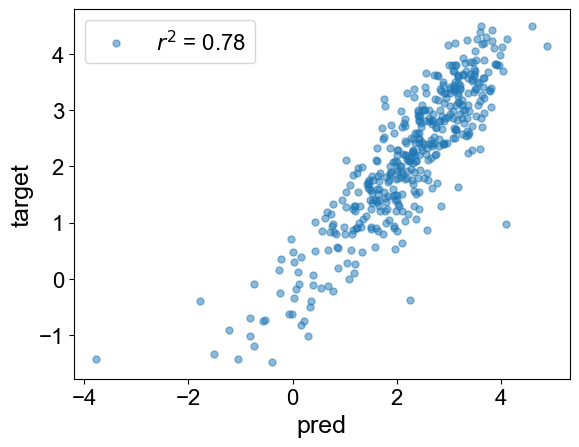

In [327]:
Xaxes = test_preds
Yaxes = [datapoint.y for datapoint in test_data[0]]

#r2 = np.corrcoef(Yaxes, Xaxes)[0, 1] ** 2

from sklearn.metrics import r2_score
r2 = r2_score(Yaxes, Xaxes)

plt.rcParams['font.family'] = 'arial'
plt.plot(Xaxes, Yaxes, '.', markersize=10, alpha=0.5)
plt.xlabel('pred', fontsize=18)
plt.ylabel('target', fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(['$r^2$ = ' + str(f"{r2:.2f}")], fontsize=16)#, loc=placeLegend
plt.show()

# Example Multi

In [176]:
chemprop_dir = Path.cwd().parent
input_path = "/Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/test-GNN/mol+mol.csv"
smiles_columns = ['smiles', 'solvent'] # name of the column containing SMILES strings
target_columns = ['peakwavs_max'] # list of names of the columns containing targets

In [177]:
df_input = pd.read_csv(input_path)
df_input

,smiles,solvent,peakwavs_max
0,CCCCN1C(=O)C(=C/C=C/C=C/C=C2N(CCCC)c3ccccc3N2C...,ClCCl,642.0
1,C(=C/c1cnccn1)\c1ccc(N(c2ccccc2)c2ccc(/C=C/c3c...,ClCCl,420.0
2,CN(C)c1ccc2c(-c3ccc(N)cc3C(=O)[O-])c3ccc(=[N+]...,O,544.0
3,c1ccc2[nH]ccc2c1,O,290.0
4,CCN(CC)c1ccc2c(c1)OC1=C(/C=C/C3=[N+](C)c4ccc5c...,ClC(Cl)Cl,736.0
...,...,...,...
95,COc1ccc(C2CC(c3ccc(O)cc3)=NN2c2ccc(S(N)(=O)=O)...,C1CCOC1,359.0
96,COc1ccc2c3c(c4ccc(OC)cc4c2c1)C1(c2ccccc2-c2ccc...,C1CCCCC1,386.0
97,CCCCOc1c(C=C2N(C)c3ccccc3C2(C)C)c(=O)c1=O,CCO,425.0
98,Cc1cc2ccc(-c3cccc4cccc(-c5ccc6cc(C)c(=O)oc6c5)...,c1ccccc1,324.0


In [178]:
smiss = df_input.loc[:, smiles_columns].values
ys = df_input.loc[:, target_columns].values

# Take a look at the first 5 SMILES strings and targets
smiss[:5], ys[:5]

(array([['CCCCN1C(=O)C(=C/C=C/C=C/C=C2N(CCCC)c3ccccc3N2CCCC)C(=O)N(CCCC)C1=S',
         'ClCCl'],
        ['C(=C/c1cnccn1)\\c1ccc(N(c2ccccc2)c2ccc(/C=C/c3cnccn3)cc2)cc1',
         'ClCCl'],
        ['CN(C)c1ccc2c(-c3ccc(N)cc3C(=O)[O-])c3ccc(=[N+](C)C)cc-3oc2c1',
         'O'],
        ['c1ccc2[nH]ccc2c1', 'O'],
        ['CCN(CC)c1ccc2c(c1)OC1=C(/C=C/C3=[N+](C)c4ccc5ccccc5c4C3(C)C)CCCC1=C2c1ccccc1C(=O)O',
         'ClC(Cl)Cl']], dtype=object),
 array([[642.],
        [420.],
        [544.],
        [290.],
        [736.]]))

In [179]:
all_data = [[data.MoleculeDatapoint.from_smi(smis[0], y) for smis, y in zip(smiss, ys)]]
all_data += [[data.MoleculeDatapoint.from_smi(smis[i]) for smis in smiss] for i in range(1, len(smiles_columns))]

In [180]:
component_to_split_by = 0 # index of the component to use for structure based splits
mols = [d.mol for d in all_data[component_to_split_by]]
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))
train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [181]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_datasets = [data.MoleculeDataset(train_data[0][i], featurizer) for i in range(len(smiles_columns))]
val_datasets = [data.MoleculeDataset(val_data[0][i], featurizer) for i in range(len(smiles_columns))]
test_datasets = [data.MoleculeDataset(test_data[0][i], featurizer) for i in range(len(smiles_columns))]

In [182]:
train_mcdset = data.MulticomponentDataset(train_datasets)
scaler = train_mcdset.normalize_targets()
val_mcdset = data.MulticomponentDataset(val_datasets)
val_mcdset.normalize_targets(scaler)
test_mcdset = data.MulticomponentDataset(test_datasets)

In [183]:
train_loader = data.build_dataloader(train_mcdset)
val_loader = data.build_dataloader(val_mcdset, shuffle=False)
test_loader = data.build_dataloader(test_mcdset, shuffle=False)

In [ ]:
mcmp = nn.MulticomponentMessagePassing(
    blocks=[nn.BondMessagePassing() for _ in range(len(smiles_columns))],
    n_components=len(smiles_columns),
)
agg = nn.MeanAggregation()
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
ffn = nn.RegressionFFN(
    input_dim=mcmp.output_dim,
    output_transform=output_transform,
)
metric_list = [metrics.RMSE(), metrics.MAE()] 
mcmpnn = multi.MulticomponentMPNN(
    mcmp,
    agg,
    ffn,
    metrics=metric_list,
)

mcmpnn

In [ ]:
mcmp = nn.MulticomponentMessagePassing(
    blocks=[nn.BondMessagePassing() for _ in range(len(smiles_columns))],
    n_components=len(smiles_columns),
)


In [185]:
agg = nn.MeanAggregation()

In [186]:
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
ffn = nn.RegressionFFN(
    input_dim=mcmp.output_dim,
    output_transform=output_transform,
)

In [187]:
metric_list = [metrics.RMSE(), metrics.MAE()] # Only the first metric is used for training and early stopping

In [188]:
mcmpnn = multi.MulticomponentMPNN(
    mcmp,
    agg,
    ffn,
    metrics=metric_list,
)

mcmpnn

MulticomponentMPNN(
  (message_passing): MulticomponentMessagePassing(
    (blocks): ModuleList(
      (0-1): 2 x BondMessagePassing(
        (W_i): Linear(in_features=86, out_features=300, bias=False)
        (W_h): Linear(in_features=300, out_features=300, bias=False)
        (W_o): Linear(in_features=372, out_features=300, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
    )
  )
  (agg): MeanAggregation()
  (bn): Identity()
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=600, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(


In [189]:
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=20, # number of epochs to train for
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [190]:
trainer.fit(mcmpnn, train_loader, val_loader)

/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /Users/kerrinjanssen/Nextcloud/PhD/Bayer/XAI/mlr-xai/notebooks/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

  | Name            | Type                         | Params | Mode 
-------------------------------------------------------------------------
0 | message_passing | MulticomponentMessagePassing | 455 K  | train
1 | agg             | MeanAggregation              | 0      | train
2 | bn              | Identity                     | 0      | train
3 |

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s, train_loss_step=0.514, val_loss=0.408, train_loss_epoch=0.704]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s, train_loss_step=0.514, val_loss=0.408, train_loss_epoch=0.704]


In [191]:
results = trainer.test(mcmpnn, test_loader)

/Users/kerrinjanssen/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     86.81767272949219     │
│         test/rmse         │     96.21236419677734     │
└───────────────────────────┴───────────────────────────┘